### ACTSC972 - Final Project 
- Josh Valchar, Andrew van den Hoeven 
- Algorithims Implemented:
    - Online Newton Step
    - BCRP 
    - UCRP
    - Universal 
    - OLMAR: Online Portfolio Selection with Moving Average Reversion

In [1]:
import numpy as np 
import pandas as pd 
from os import walk 
from datetime import datetime
from __future__ import division
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt 
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
from scipy.optimize import minimize 

### Data Loading and Preprocessing 

In [2]:
date_conv = lambda x: pd.to_datetime(x)

In [3]:
def data_reader(tickers, source, start_date, end_date = None):
    '''
    function that reads data from yahoo finance/ quandl data sources
    inputs:
    tickers -- stock tickers
    source -- 'quandl', 'yahoo'
    start_date -- start of pricing information
    end_date -- end of pricing information 
    returns:
    '''
    data = DataReader(tickers, source, start_date, end_date)
    return data 

In [4]:
def tradable_stocks():
    '''
    List of S&P500 stocks that contain a 30 year price history 
    '''
    return ['AAPL','ABT','AET','ARNC','AXP','BAC','BCR','BDX','CI','CLX','CMC','CMI','CRS','CSX','DIS','DUK','EMR',
            'FDX','GE','GIS','GPC','HON','HPQ','IBM','IFF','INTC','KO','LLY','LNC','MCD','MEI','NEE','NEM','SHW','SLB',
            'TAP','TGT','TXT','WFC','WMB'
           ]

In [5]:
def tradable_csvs():
    '''
    List of S&P500 csv files available. All stocks contain a 30 year price history. This allows one to avoid API call limits
    '''
    return ['AAPL.csv','ABT.csv','AET.csv','ARNC.csv','AXP.csv','BAC.csv','BCR.csv','BDX.csv','CI.csv','CLX.csv','CMC.csv',
            'CMI.csv','CRS.csv','CSX.csv','DIS.csv','DUK.csv','EMR.csv','FDX.csv','GE.csv','GIS.csv','GPC.csv','HON.csv',
            'HPQ.csv','IBM.csv','IFF.csv','INTC.csv','KO.csv','LLY.csv','LNC.csv','MCD.csv','MEI.csv','NEE.csv','NEM.csv','SHW.csv',
            'SLB.csv','TAP.csv','TGT.csv','TXT.csv','WFC.csv','WMB.csv'
           ]

In [6]:
def stock_df(n, start_date, csv = None,):
    '''
    function that takes as input a portolio size n and returns a dataframe that contains a number of stocks  
    '''
    # select n stock csv files 
    if csv != None:
        filenames = csv
    else:
        filenames = tradable_csvs()[0:n]
    # construct empty data frame to hold financial data
    ret_df = pd.DataFrame()
    price_df = pd.DataFrame()
    for f in filenames:
        series = pd.read_csv('C://Users//Josh//Desktop//ACTSC972_project//data//' + f)
        series['Date'] = series['Date'].apply(date_conv)
        series = series.set_index('Date')
        series = series['Adj Close']
        series = series.loc[series.index >= start_date].astype('float')
        series_ret = series.iloc[0:-1].as_matrix()/series.iloc[1:].as_matrix()
        ret_df[f.split('.')[0]] = series_ret
        price_df[f.split('.')[0]] = series
    return ret_df.as_matrix(), price_df     

### Algorithms 

#### 1. Online Newton Step 

In [7]:
def init_port(m):
    '''
    Calculate the initial porfolio weights for period 1 
    m -- number of stocks
    returns:
    p_0 -- initial 1/m portfolio weights
    '''
    p_0 = np.ones([m,1])/m
    return p_0

In [8]:
def init_step(m):
    '''
    Initialize A and b matrices in Online Newton Step calculation 
    input:
    m -- size of portfolio
    returns 
    A -- initialized matrix A
    b -- initialized vector b 
    '''
    A = np.mat(np.eye(m))
    b = np.mat(np.zeros(m))
    return A, b

In [9]:
def step(p,r, A, b):
    '''
    Function that performs the Online Newton Step for t > 1 
    p -- current portfolio weights
    r -- returns 
    '''
    # calculate the gradient
    grad = np.mat(r/np.dot(p.T, r)).T
    #update matrix A
    A += grad*grad.T
    #update b parameter
    b += (1 + 1./beta)*grad
    M = delta*A.I*b.T
    pp = projection(M, A)
    return pp * (1-eta) + np.ones(len(r))/float(len(r))*eta

In [10]:
def projection(x,M):
    '''
    Projection of x into the simplex 
    '''
    m = M.shape[0]
    
    P = matrix(2*M)
    q = matrix(-2*M*x)
    G = matrix(-np.eye(m))
    h = matrix(np.zeros((m,1)))
    A = matrix(np.ones((1,m)))
    b = matrix(1.)
    sol = solvers.qp(P, q, G, h, A,b)
    return np.squeeze(sol['x'])

In [11]:
def ONS(ret, freq=1, delta = 1/8, beta = 1, eta = 0):
    '''
    Implementation of the Online Newton Step 
    inputs:
    ret -- daily returns
    freq -- trading frequency
    delta, beta, eta -- model parameters specified in Agarwal et al. 2006
    returns:
    p -- vector of portfolio weights
    '''
    m = ret.shape[1]
    
    # algorithm initialization
    p0 = init_port(m)
    p = np.zeros(ret.shape)
    p[0,:] = init_port(m).reshape(m,)
    A, b = init_step(m)
    for i in range(1, ret.shape[0], freq):
        p[i,:] = step(p[i-1], ret[i-1].reshape(p0.shape), A,b)
    return p 

#### 2. Best CRP 
- Best Constant Rebalanced Portfolio assuming that we are optimizing log returns over the specified trading period

In [12]:
def optimal_weights(ret, max_leverage = 1.0):
    '''
    Function that finds the best constant rebalanced portfolio with respecto returns 
    inputs:
    ret-- relative price vector
    max_leverage -- maximum leverage
    '''
    # in the paper delta = 0.0001: can't 
    def obj(p, ret = ret, sgn = -1):
        ''' define objective function to be maximized to find optimal weights'''
        portfolio_returns = sgn*np.sum(np.log(np.maximum(np.dot(p, ret.T-1) + 1, 0.0001)))  # take element wise maximum
        return portfolio_returns 
    # we assume that no wealth is held in cash 
    cons = ({'type':'eq', 'fun':lambda p: max_leverage - sum(p)},)
    x0 = max_leverage*np.ones(ret.shape[1])/float(ret.shape[1])
    while True:
        res = minimize(obj, x0, bounds = [(0., max_leverage)]*len(x0), constraints = cons, method = 'slsqp')
        #res = minimize(obj, x0, constraints = cons, method = 'slsqp')
        EPS = 1E-7
        if (res.x <0.-EPS).any() or (res.x > max_leverage + EPS).any():
            ret = ret + np.random.randn()*EPS
            logging.debug('Optimal weights not found, trying again...')
        elif res.success:
            break
    return np.full(ret.shape,res.x)

#### 3. Uniform Constant Rebalanced Portfolio 

In [13]:
def uniform_weights(ret):
    '''
    function that takes as input a matrix of returns and produces a vector of uniformly distributed weights
    '''
    return np.full(ret.shape, 1/ret.shape[1])

#### 4. Universal Portfolio 

In [14]:
def simplex(dim, points):
    '''
    Sample random points from simplex (i.e., generating random portfolios)
    inputs:
    dim -- number of dimensions d
    points -- number of evaluation points 
    '''
    a = np.sort(np.random.random((points, dim)))
    a = np.hstack([np.zeros((points,1)), a, np.ones((points,1))])
    return np.diff(a)

In [15]:
def init_universal_step(ret, leverage):
    '''
    create a mesh on simplex and retain wealth of all strategies
    '''
    m = ret.shape[1]
    W = np.matrix(simplex(m-1, eval_points))
    S = np.matrix(np.ones(W.shape[0])).T
    
    # stretch simplex based on leverage 
    leverage = max(leverage, 1./m)
    stretch = (leverage - 1./m) / (1. - 1/m)
    W = (W - 1./m) * stretch + 1./m
    return W, S 

In [16]:
def universal_step(ret_vec, last_p, S, W):
    '''
    calculate new wealth of all CRPs
    '''
    S = np.multiply(S, W*np.matrix(ret_vec).T)
    p = W.T*S
    return p/sum(p)

In [17]:
def universal_portfolio(ret, eval_points, leverage):
    '''
    function that performs the universal portfolio algorithm 
    '''
    p0 = init_port(ret.shape[1]).reshape((ret.shape[1],))      # initialize period 1 portfolio
    p = np.zeros(ret.shape)
    p[0,:] = p0
    W, S = init_universal_step(ret, leverage)
    for i in range(1, ret.shape[0]):
        p[i,:] = universal_step(ret[i,:], p[i-1,:], S, W).reshape((ret.shape[1],))
    return p 

#### 5. Online portfolio selection with moving average reversion

In [18]:
def olmar_step(x, last_p, history):
    '''
    calculate return prediction
    '''
    #print(x, history)
    x_pred = predict(x, history)
    p = olmar_update(last_p, x_pred, eps)
    return p  

In [19]:
def predict(x, history):
    '''predict returns on next day'''
    return (np.divide(history, x)).mean(axis=0)

In [20]:
def olmar_update(p, x ,eps):
    '''
    Update portfolio weights to satisfy constraint b * x >=eps
    and minimize distance to previous weights
    '''
    x_mean = np.mean(x)
    #print(x, p)
    lam = max(0., (eps - np.dot(x,p)) / np.linalg.norm(x-x_mean)**2)
    #print(lam)
    # limit lambda to avoid numerical problems
    lam = min(100000, lam)
    
    # update portfolio 
    p = p.T + lam * (x - x_mean)
    #print(p)
    # project into simplex
    return simplex_proj(p)

In [21]:
def simplex_proj(y):
    '''
    Projection of y onto simplex
    '''
    m = len(y)
    bget = False
    
    s = sorted(y, reverse=True)
    tmpsum = 0.
    
    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1)
        if tmax >= s[ii-1]:
            bget = True
            break
    if not bget:
        tmax = (tmpsum + s[m-1]-1)/m
    return np.maximum(y-tmax,0.)

In [87]:
def olmar(ret, window, eps):
    '''
    Function that performs On-Line Portfolio Selection with Moving Average Reversion
    '''
    # initial weights
    m = ret.shape[1]
    p0 = init_port(m).reshape((ret.shape[1],)) 
    p = np.zeros(ret.shape)
    p[0,:] = p0
    for i in range(1, ret.shape[0]):
        hist = ret[:i+1,:]
        hist = hist[max(-(i+1),-window):,:]
        p[i,:] = olmar_step(ret[i,:],p[i-1], hist)
    return p

#### 6. Multiplicative Updates (Exponential Gradient) 

In [92]:
def eg(ret, eta):
    '''
    Implementation of 'On-Line Portfolio Selection Using Multiplicative Updates'
    '''
    p0 = init_port(ret.shape[1]).reshape((ret.shape[1],))
    p = np.zeros(ret.shape)
    p[0,:] = p0
    for i in range(1, ret.shape[0]):
        p[i,:] = eg_step(p[i-1,:], ret[i-1,:])
    return p 

In [94]:
def eg_step(p_prev, ret_prev):
    '''
    Exponential Gradient Update 
    inputs:
    p_prev -- previous periods portfolio
    ret_prev -- previous periods returns
    returns:
    p_update -- next periods updated porfolio weights
    '''
    p = np.multiply(p_prev, np.exp(eta*(ret_prev)/np.dot(p_prev,ret_prev)))/np.sum(np.multiply(p_prev,np.exp(eta*ret_prev)/np.dot(p_prev,ret_prev)))
    return p 

#### Plotting Functions 

In [158]:
def exp1_plot(weights, algorithm):
    '''
    Function that produces main visualizations for IBM vs AAPL portfolio management 
    '''
    plt.figure(figsize = (15,10))
    plt.subplot(2,1,1)
    plt.plot(weights[:,1], color = 'blue')
    plt.plot(weights[:,0], color = 'grey')
    plt.title( algorithm + ' ' + 'Portfolio Holdings')
    plt.legend(['IBM', 'AAPL'])
    plt.subplot(2,1,2)
    plt.plot(price_df['IBM'], color = 'blue')
    plt.plot(price_df['AAPL'], color = 'grey')
    plt.title('Adjusted Close')
    plt.legend(['IBM', 'AAPL'])
    plt.show()

In [170]:
def exp2_plot(weights, algorithm):
    plt.figure(figsize = (15,10))
    plt.subplot(2,1,1)
    plt.plot(weights)
    plt.legend(price_df.columns)
    plt.title(algorithm + ' ' +  'Portfolio Holdings')
    plt.subplot(2,1,2)
    plt.plot(price_df)
    plt.legend(price_df.columns)
    plt.title('Adjusted Close')
    plt.show()

#### Experiment 1: Stock Tracking Experiment with ONS 

#### IBM vs. AAPL

In [171]:
start_date = datetime(2000, 9, 10)
csvs = ['AAPL.csv', 'IBM.csv']
ret, price_df = stock_df(0, start_date, csv = csvs)

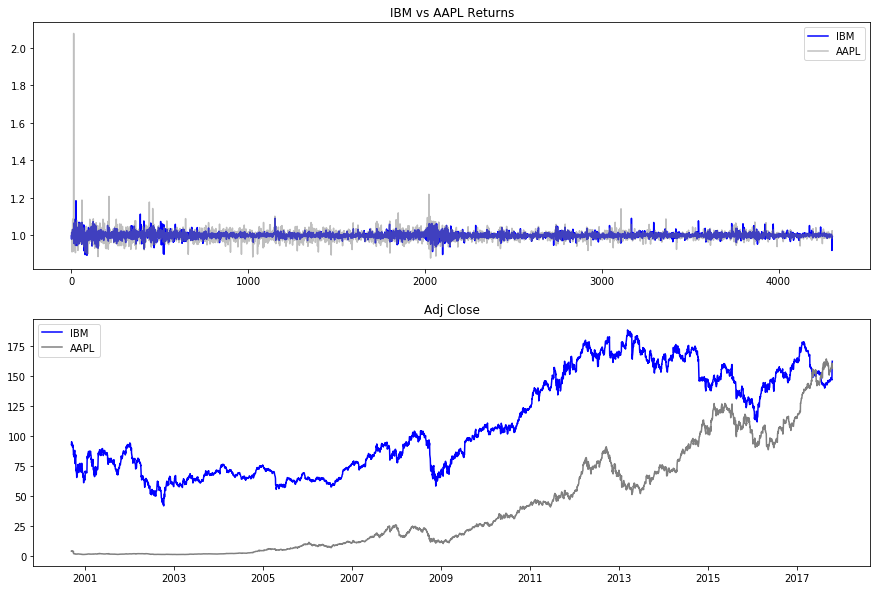

In [172]:
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
plt.plot(ret[:,1], color = 'blue')
plt.plot(ret[:,0], color = 'grey', alpha = 0.5)
plt.title('IBM vs AAPL Returns')
plt.legend(['IBM', 'AAPL'])
plt.subplot(2,1,2)
plt.plot(price_df['IBM'], color = 'blue')
plt.plot(price_df['AAPL'], color = 'grey')
plt.title('Adj Close')
plt.legend(['IBM', 'AAPL'])
plt.show()

In [173]:
# model parameters 
m = ret.shape[1]    
delta = 1/8
beta = 1 
eta = 0.05    # learning parameter for multiplicative weights

In [174]:
# Universal Portfolio Parameters 
eval_points = int(1E4)
leverage = 1.5

In [175]:
# window length must be greater than 2 and eps must be greater than  
window = 5        # lookback window  
eps = 10         # constraint on return for new weights on last price (average of prices) 

In [176]:
ons_p = ONS(ret)
bcrp = optimal_weights(ret)
universal = universal_portfolio(ret, eval_points, leverage)
olmar_p = olmar(ret, window, eps)
eg_p = eg(ret, eta)

#### Plots 

#### ONS

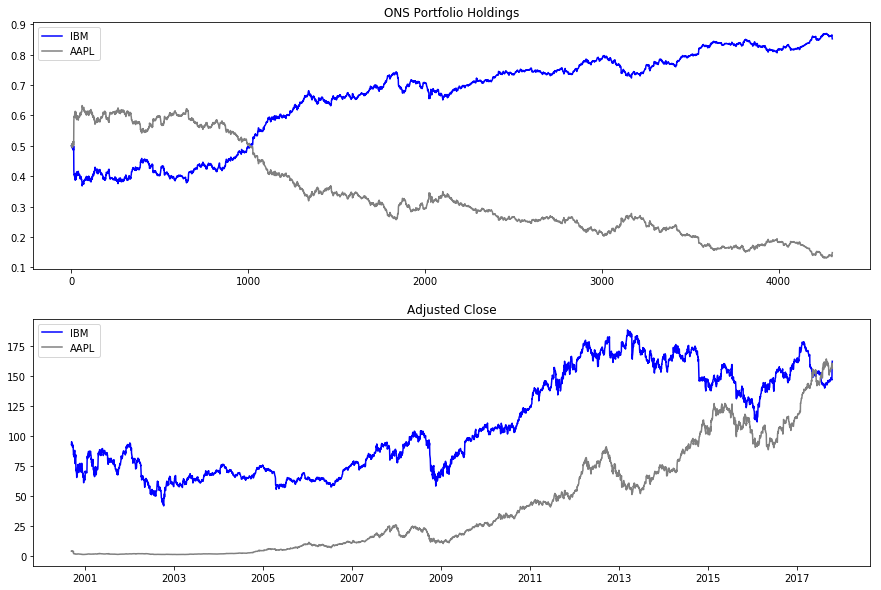

In [177]:
exp1_plot(ons_p, 'ONS')

#### Universal 

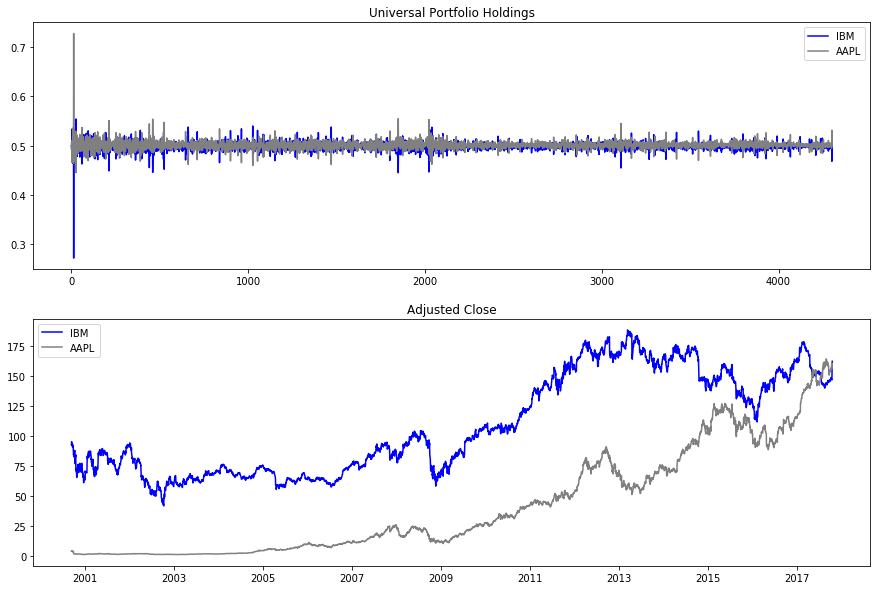

In [178]:
exp1_plot(universal, 'Universal')

#### OLMAR 

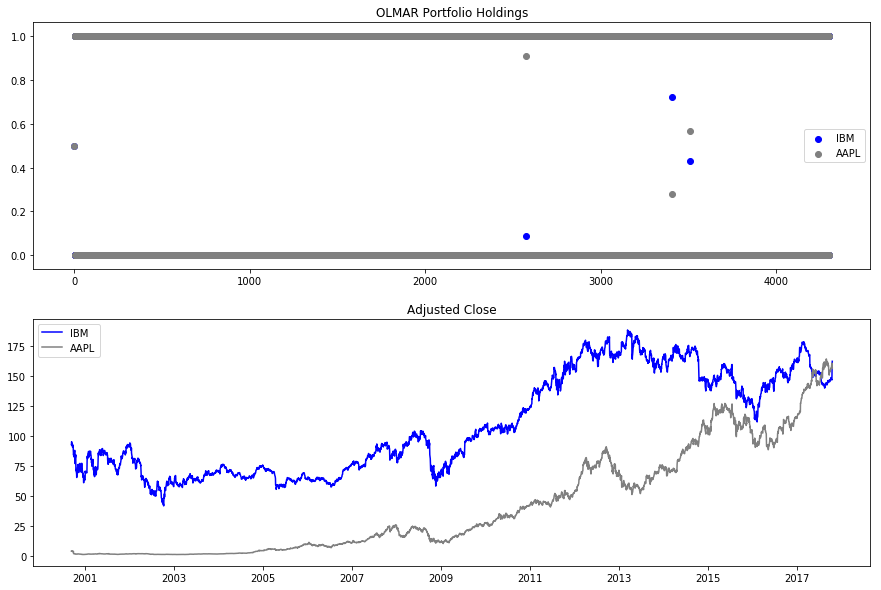

In [179]:
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
plt.scatter(np.array([i for i in range(len(olmar_p))]),olmar_p[:,1], color = 'blue')
plt.scatter(np.array([i for i in range(len(olmar_p))]) ,olmar_p[:,0], color = 'grey')
plt.title( 'OLMAR Portfolio Holdings')
plt.legend(['IBM', 'AAPL'])
plt.subplot(2,1,2)
plt.plot(price_df['IBM'], color = 'blue')
plt.plot(price_df['AAPL'], color = 'grey')
plt.title('Adjusted Close')
plt.legend(['IBM', 'AAPL'])
plt.show()

#### EG 

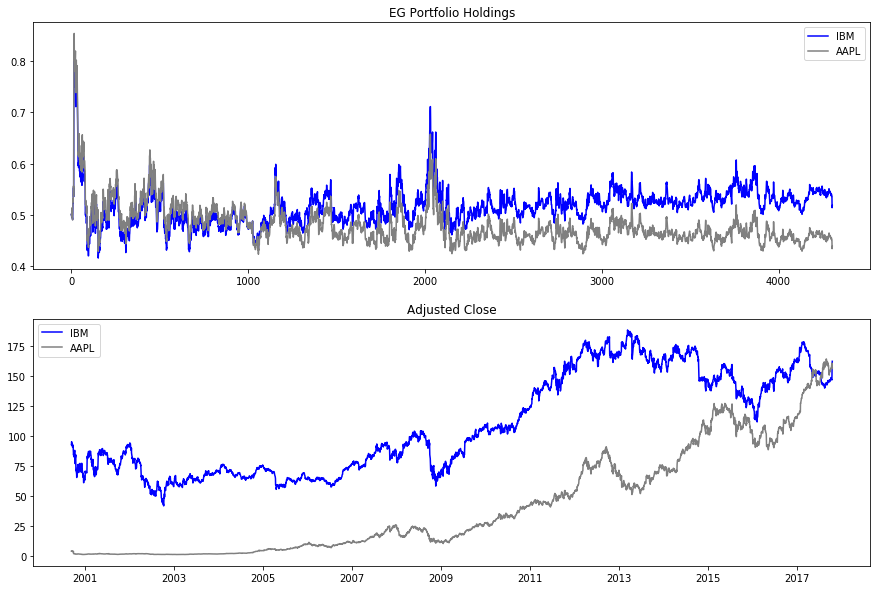

In [180]:
exp1_plot(eg_p, 'EG')

#### Comparison 

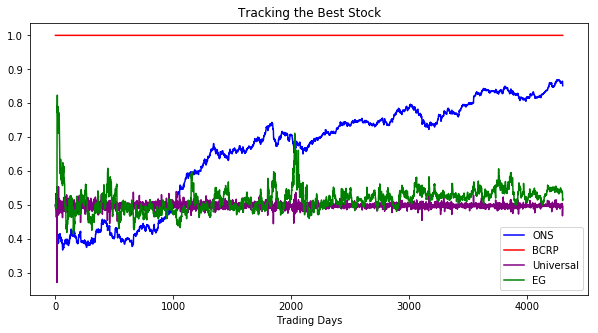

In [181]:
plt.figure(figsize = (10,5))
plt.plot(ons_p[:,1], color = 'blue')
plt.plot(bcrp[:,1], color = 'red')
plt.plot(universal[:,1], color = 'purple')
plt.plot(eg_p[:,1], color = 'green')
plt.title('Tracking the Best Stock')
plt.xlabel('Trading Days')
plt.legend(['ONS', 'BCRP', 'Universal', 'EG'])
plt.show()

#### Experiment 2:  Five Stock Portfolio 

In [182]:
n = 5
ret, price_df = stock_df(n,start_date)

In [183]:
ons_p = ONS(ret)
bcrp = optimal_weights(ret)
universal = universal_portfolio(ret, eval_points, leverage)
olmar_p = olmar(ret, window, eps)
eg_p = eg(ret, eta)

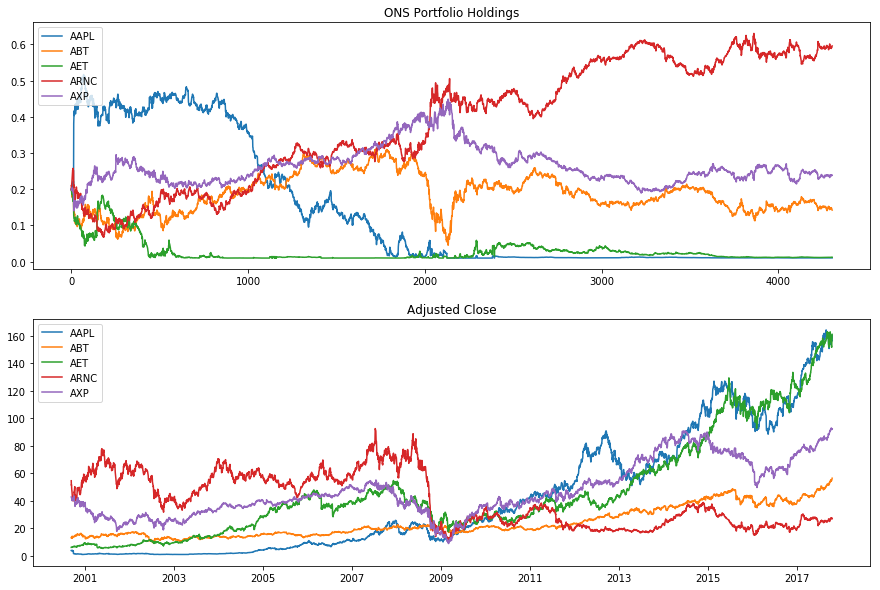

In [184]:
exp2_plot(ons_p, 'ONS')

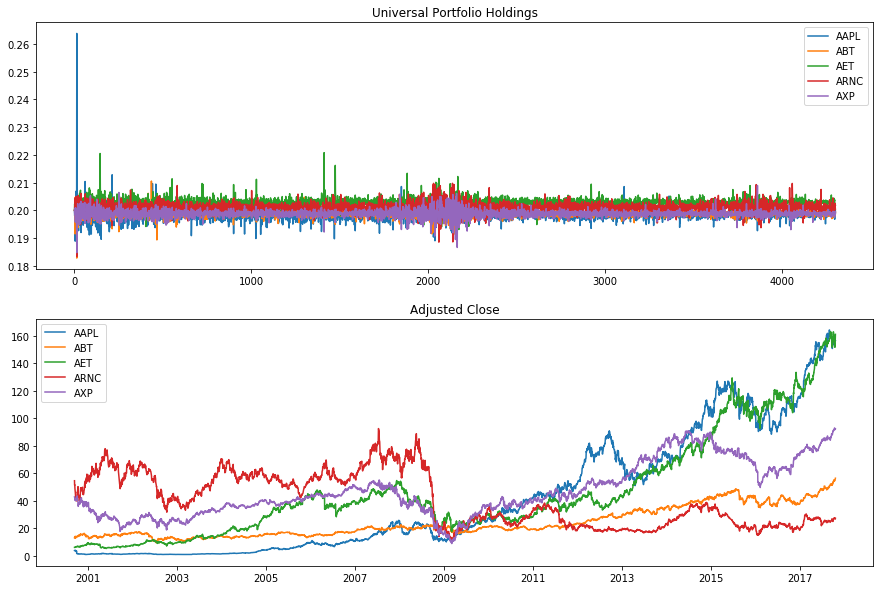

In [185]:
exp2_plot(universal, 'Universal')

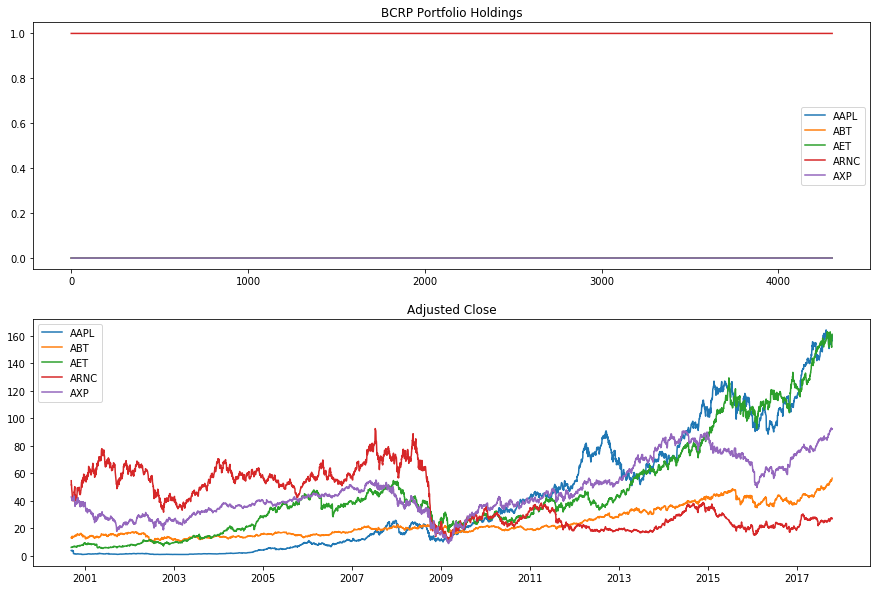

In [187]:
exp2_plot(bcrp, 'BCRP')

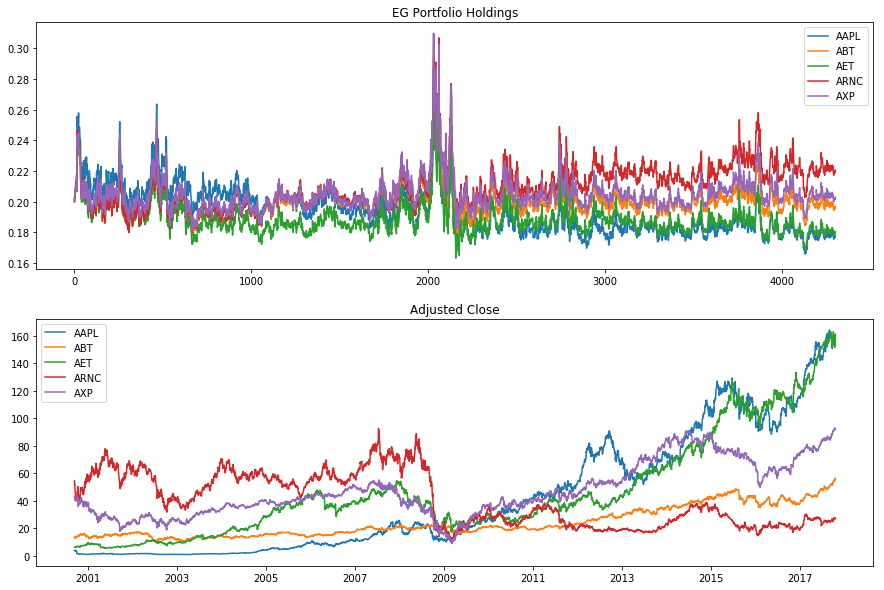

In [188]:
exp2_plot(eg_p, 'EG')

#### Experiment 3: Performance vs. Portfolio Size  

In [189]:
def logarithmic_growth(p, ret, freq):
    '''
    Function that computes the Logarithmic Growth Ratio 
    inputs:
    p -- portfolio weights
    ret -- matrix of returns
    freq -- number of trading/compounding periods
    returns:
    log_growth -- Annual Percentage Yield 
    '''
    log_growth = np.sum(np.log(np.dot(p.T, ret)))
    return log_growth

In [190]:
portfolio_size = np.array([i for i in range(10, 44, 5)])
m = len(portfolio_size)

In [191]:
log_growth = np.zeros([m,1])
log_growth2 = np.zeros([m,1])
freq = 1 

In [192]:
for i in range(m):
    ret, price_df = stock_df(portfolio_size[i],start_date)
    p = ONS(ret)
    ucrp = optimal_weights(ret)
    log_growth[i] = logarithmic_growth(p, ret, freq)
    log_growth2[i] = logarithmic_growth(ucrp, ret, freq)

C:\Users\Josh\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


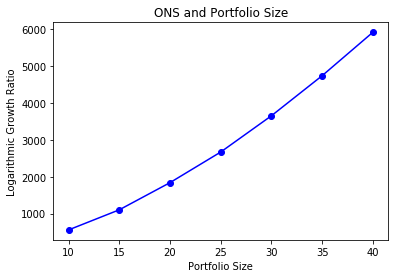

In [195]:
plt.figure()
plt.plot(portfolio_size, log_growth, '-o', color = 'blue')
plt.plot(portfolio_size, log_growth2, '--', color = 'red')
plt.xlabel('Portfolio Size')
plt.ylabel('Logarithmic Growth Ratio')
plt.title('ONS and Portfolio Size')
plt.show()